# dmarketing.ai

### Deep Learning

### Project: Build a reviews' classifier based on Amazon's reviews dataset

<font color=red>__*Provide project's description here*__</font>

### Step 0: Load The Data 

In [1]:
import os

DATA_FOLDER_PATH = "./data"
TRAIN_DATA_PATH = os.path.join(DATA_FOLDER_PATH, 'train.csv')
TEST_DATA_PATH = os.path.join(DATA_FOLDER_PATH, 'test.csv')

In [2]:
def count_samples(csv_file_path):
    samples_cnt = 0

    with open(csv_file_path, 'r', errors='ignore') as csv_file:
        for lines in csv_file:
            samples_cnt += 1
    return samples_cnt

In [3]:
train_samples = count_samples(TRAIN_DATA_PATH)
test_samples = count_samples(TEST_DATA_PATH)

In [4]:
print("Number of train samples : {}\nNumber of test samples : {}".format(train_samples, test_samples))

Number of train samples : 3000000
Number of test samples : 650000


In [5]:
import csv, string

RATING_IDX = 0
TITLE_IDX = 1
REVIEW_IDX = 2

def flow_from_csv(path=None, col_idx=REVIEW_IDX):
    '''Produces generator that iterates through col_idxes in csv file containg data.
                
            Parameters:
            path (str): file system path to a csv file with data samples.
            loc_idx(int): number of column.
                
            Returns:
            generator: generator that returns data from each row specified by col_idx.
     '''
    with open(path, 'r', errors='ignore') as csv_file:
        reader = csv.reader(csv_file)
        
        readed_cnt = 0
        while readed_cnt != train_samples - 1:
            row = next(reader)
            
            text = row[col_idx].lower()
            text = text.translate(str.maketrans('', '', string.punctuation))
            
            readed_cnt += 1
            yield text
            
    return

### Step 1: Dataset Summary & Explonation

<font color=red>__*Feature descriptions*__</font>

In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer

max_words = 10000

tokenizer = Tokenizer(num_words=max_words)
review_gen = flow_from_csv(TRAIN_DATA_PATH, REVIEW_IDX)

tokenizer.fit_on_texts(review_gen)

<BarContainer object of 30 artists>

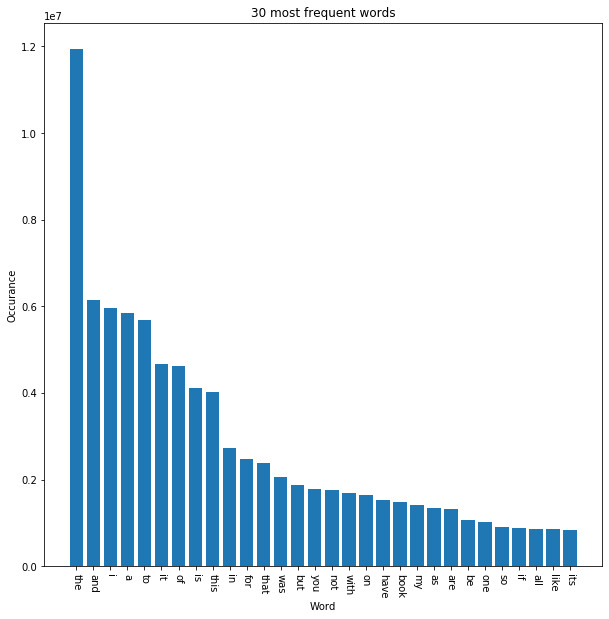

In [7]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

word_cnt = tokenizer.word_counts

# Extracts the most frequent words
most_freq_words = 30

sorted_items = list(word_cnt.items())
sorted_items.sort(key=lambda item: item[-1], reverse=True)

most_freq_keys = [k for k, v in sorted_items[:most_freq_words]]
most_freq_values = [v for k, v in sorted_items[:most_freq_words]]

# Draws bar char of most frequent words
plt.figure(figsize=(10, 10))
plt.title(str(most_freq_words) + " most frequent words")
plt.xlabel("Word")
plt.xticks(rotation=-90)
plt.ylabel("Occurance")
plt.bar(most_freq_keys, most_freq_values)

### Step 2: Design and Validate a Model Architecture 

<font color=red>__*Neural Net architecture descriptions tested*__</font>

In [225]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

classes = ["negative", "neutral", "positive"]
# Returns index of a corresponding class in classes list
rating2class = {'1': 0,
                '2': 0,
                '3': 1,
                '4': 2,
                '5': 2}

NUMBER_OF_CLASSES = len(classes)         # Returns number of unique values in rating2class dict 

In [226]:
def skip_rows(gen, num):
    '''Skips rows of csv file read by genertor.

            Parameters:
            gen (generator): csv file reader generator.
            num (int): number of row to be skipped.
    '''
    skipped = 0
    while skipped != num:
        next(gen)
        skipped += 1;

In [227]:
def data_pipeline(path, maxlen, batch_size=1, start_idx=0):
    '''Produces generator that will be used to train neural network.

            Parameters:
            path (str): file system path to a csv file with data samples.

            Returns:
            generator: generator that returns tuple(list_of_reviews, list_of_outputs).
    '''
    csv_file = open(path, 'r', errors='ignore')
    reader = csv.reader(csv_file)

    readed_cnt = start_idx
    skip_rows(reader, start_idx)

    while True:
        reviews = []
        ratings = []

        for _ in range(batch_size):
            row = next(reader)
            # Extract ratings
            rating = row[RATING_IDX]
            rating_class = rating2class[rating]
            ratings.append(rating_class)

            # Extract and clear reviews
            review = row[REVIEW_IDX].lower()
            review = review.translate(str.maketrans('', '', string.punctuation))
            reviews.append(review)

            readed_cnt += 1

        # Tokenize and pad sequences
        reviews = tokenizer.texts_to_sequences(reviews)
        reviews = pad_sequences(reviews, maxlen=maxlen)
        
        # Converting input to binary class matrix
        ratings = to_categorical(ratings, num_classes=NUMBER_OF_CLASSES, dtype='uint8')
            
        yield reviews, ratings, [None]
            
        # Provides infinite data generation
        if readed_cnt + batch_size >= train_samples - 1:
            csv_file.close()
            csv_file = open(path, 'r', errors='ignore')
            reader = csv.reader(csv_file)
            readed_cnt = start_idx
            # Skip first start_idx rows
            skip_rows(reader, start_idx)

In [228]:
max_len = 80    # Maximal length of a sequence that can be feed to neural network

model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(max_words, 128, input_length=max_len),
    tf.keras.layers.GRU(64, recurrent_dropout=0.2, dropout=0.2),
    tf.keras.layers.Dense(NUMBER_OF_CLASSES, activation='softmax')
])

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

In [199]:
model.summary()

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_32 (Embedding)     (None, 100, 256)          2560000   
_________________________________________________________________
gru_22 (GRU)                 (None, 128)               148224    
_________________________________________________________________
dense_31 (Dense)             (None, 3)                 387       
Total params: 2,708,611
Trainable params: 2,708,611
Non-trainable params: 0
_________________________________________________________________


In [200]:
tensorboard_cb = [
    tf.keras.callbacks.TensorBoard(
                                log_dir='best_sequential_model',
                                histogram_freq=1,
                                embeddings_freq=1)
]

In [229]:
data_gen = data_pipeline(TRAIN_DATA_PATH, maxlen=max_len, batch_size=256, start_idx=0)
val_gen = data_pipeline(TRAIN_DATA_PATH, maxlen=max_len, batch_size=256, start_idx=2 * 10^6)

history = model.fit(data_gen, steps_per_epoch=1000,
                    epochs=40, 
                    validation_data=val_gen,
                    validation_steps=500,
                    callbacks=tensorboard_cb)

Train for 1000 steps, validate for 500 steps
Epoch 1/40
1000/1000 [==============================] - 218s 218ms/step - loss: 0.7778 - acc: 0.6610 - val_loss: 0.6720 - val_acc: 0.7134
Epoch 2/40
1000/1000 [==============================] - 214s 214ms/step - loss: 0.6764 - acc: 0.7119 - val_loss: 0.6391 - val_acc: 0.7313
Epoch 3/40
1000/1000 [==============================] - 212s 212ms/step - loss: 0.6500 - acc: 0.7244 - val_loss: 0.6219 - val_acc: 0.7375
Epoch 4/40
1000/1000 [==============================] - 211s 211ms/step - loss: 0.6357 - acc: 0.7315 - val_loss: 0.6150 - val_acc: 0.7417
Epoch 5/40
1000/1000 [==============================] - 219s 219ms/step - loss: 0.6233 - acc: 0.7378 - val_loss: 0.6062 - val_acc: 0.7435
Epoch 6/40
1000/1000 [==============================] - 213s 213ms/step - loss: 0.6071 - acc: 0.7446 - val_loss: 0.5996 - val_acc: 0.7479
Epoch 7/40
1000/1000 [==============================] - 207s 207ms/step - loss: 0.6041 - acc: 0.7462 - val_loss: 0.5889 - val_a

In [230]:
model.save('best_sequential_model.h5')

### Step 3: Test a Model on New Reviews

In [74]:
def test():
    pass

### Step 4: Summary

<font color=red>__*Final conclusions*__</font>